Hypotheses

Null Hypothesis (H₀): Humidity and temperature metrics have no significant effect on the probability of avian deaths occurring.

Alternative Hypothesis (H₁): Humidity and/or temperature metrics have a significant effect on the probability of avian deaths occurring.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy import stats

In [11]:
df=pd.read_excel('weather dataset for uk.xlsx')
df.head()

,Region,Year,Month,Avg Temp,Max Temp,Min Temp,Humidity,Weather,Total Death,Probablity
0,East of England,2012,1,3.2,6.1,0.3,87,"Cloudy, Frost",2,1
1,East of England,2012,2,4.1,7.4,0.8,83,"Fog, Drizzle",0,0
2,East of England,2012,3,6.9,11.2,2.5,78,Sunny Intervals,0,0
3,East of England,2012,4,8.5,12.8,4.1,76,Showers,0,0
4,East of England,2012,5,11.9,16.5,7.3,72,Sunny,0,0


In [14]:
# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('.', '', regex=False)
# Convert categorical 'region' and 'weather' to dummy variables
df_encoded = pd.get_dummies(df, columns=['region', 'weather'], drop_first=True)

# Display the cleaned and encoded DataFrame columns
df_encoded.columns

Index(['year', 'month', 'avg_temp', 'max_temp', 'min_temp', 'humidity',
       'total_death', 'probablity', 'region_East of England', 'region_London',
       ...
       'weather_Windy', 'weather_Windy, Drizzle', 'weather_Windy, Rain',
       'weather_Windy, Wet', 'weather_Windy, mild',
       'weather_Windy, occasional rain', 'weather_Windy, rain',
       'weather_Windy, showers', 'weather_Windy, wet',
       'weather_Wintry showers'],
      dtype='object', length=734)

In [34]:
# Define predictors and response
X = df[['avg_temp', 'humidity']]
y = df['probablity']

In [36]:
# Add constant for statsmodels (intercept term)
X_sm = sm.add_constant(X)

# Fit logistic regression model
logit_model = sm.Logit(y, X_sm)
result = logit_model.fit()

# Print summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.379738
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             probablity   No. Observations:                 1848
Model:                          Logit   Df Residuals:                     1845
Method:                           MLE   Df Model:                            2
Date:                Tue, 22 Apr 2025   Pseudo R-squ.:                0.008622
Time:                        11:53:46   Log-Likelihood:                -701.75
converged:                       True   LL-Null:                       -707.86
Covariance Type:            nonrobust   LLR p-value:                  0.002235
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.1141      1.764     -3.467      0.001      -9.571      -2.657
avg_temp       0.0725      0.

In [38]:
# Calculate odds ratios
print("\nOdds Ratios:")
print(np.exp(result.params))


Odds Ratios:
const       0.002212
avg_temp    1.075181
humidity    1.043699
dtype: float64


In [40]:
# Calculate confidence intervals for odds ratios
print("\nConfidence Intervals for Odds Ratios:")
conf_int = result.conf_int()
conf_int['Odds Ratio'] = np.exp(conf_int[0])
conf_int.columns = ['2.5%', '97.5%', 'Odds Ratio']
print(conf_int)


Confidence Intervals for Odds Ratios:
              2.5%     97.5%  Odds Ratio
const    -9.570917 -2.657195    0.000070
avg_temp  0.024165  0.120814    1.024459
humidity  0.005077  0.080465    1.005090


In [48]:
# Split data for sklearn implementation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit sklearn model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [46]:
# Predictions
y_pred = logreg.predict(X_test)

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       491
           1       0.00      0.00      0.00        64

    accuracy                           0.88       555
   macro avg       0.44      0.50      0.47       555
weighted avg       0.78      0.88      0.83       555



C:\Users\tajdi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tajdi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tajdi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [50]:
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[491   0]
 [ 64   0]]


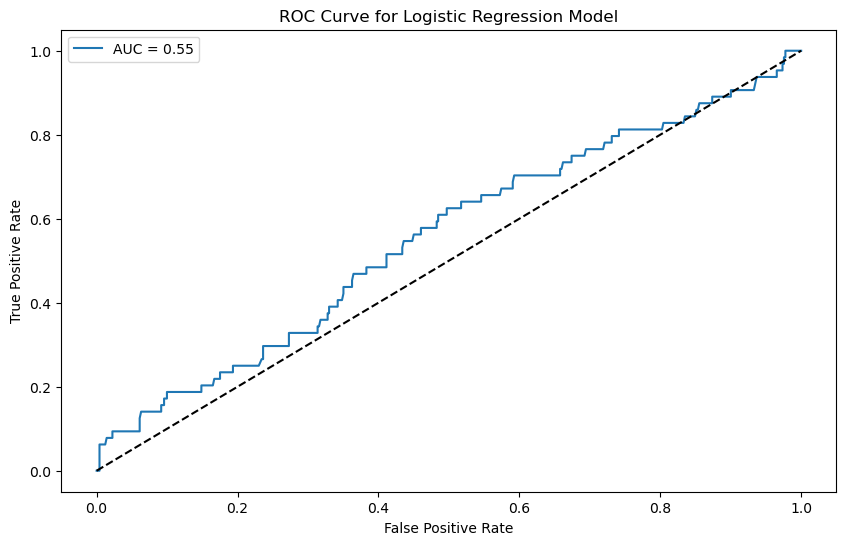

In [52]:
# ROC Curve
y_pred_proba = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression Model')
plt.legend()
plt.show()

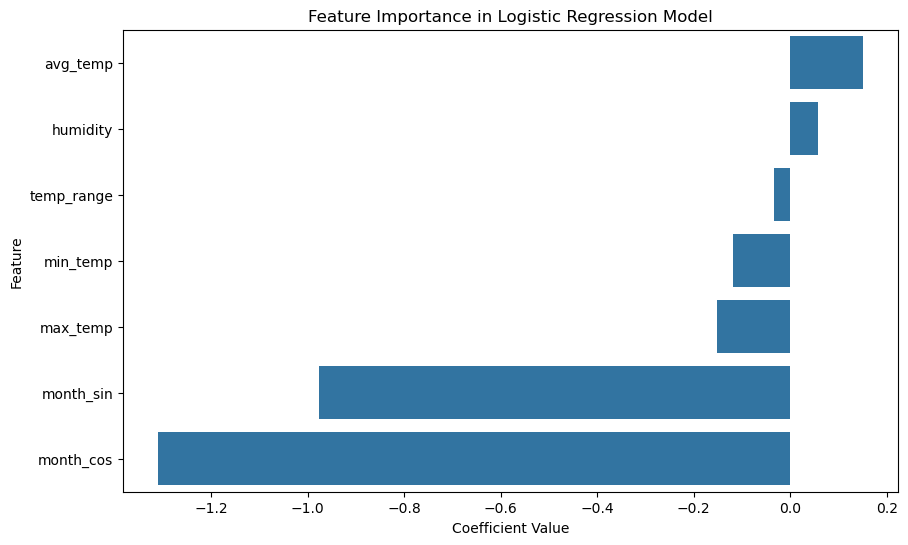

In [75]:
# Feature Importance Plot
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': logreg.coef_[0]})
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Feature Importance in Logistic Regression Model')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

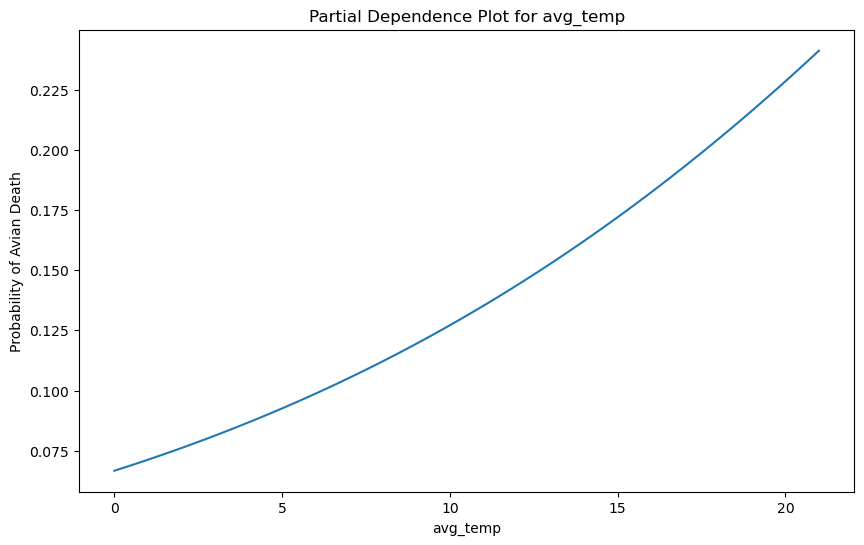

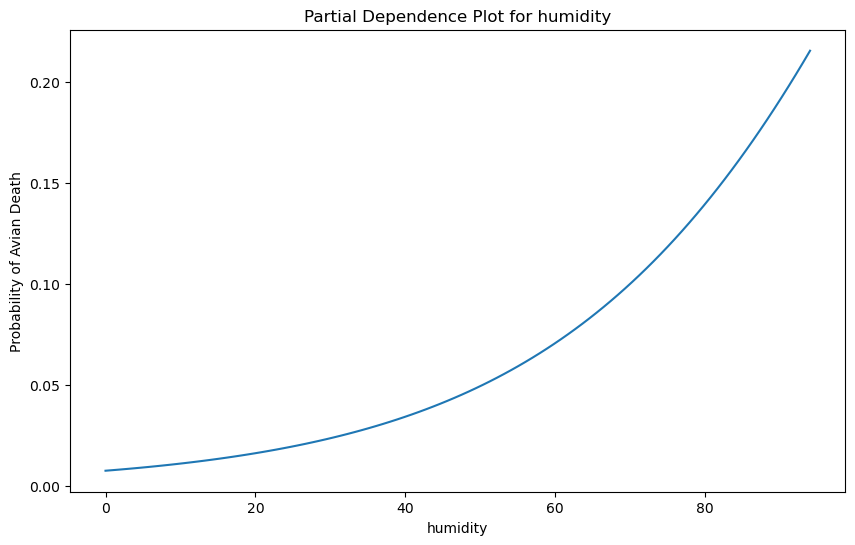

In [56]:
# Partial dependence plots for key variables
def partial_dependence_plot(model, X, feature, grid_resolution=100):
    """Create partial dependence plot for a single feature"""
    # Create grid of values for the feature
    x_grid = np.linspace(X[feature].min(), X[feature].max(), grid_resolution)
    
    # Calculate partial dependence
    y_pred = []
    for x in x_grid:
        X_temp = X.copy()
        X_temp[feature] = x
        y_pred.append(model.predict_proba(X_temp)[:, 1].mean())
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(x_grid, y_pred)
    plt.xlabel(feature)
    plt.ylabel('Probability of Avian Death')
    plt.title(f'Partial Dependence Plot for {feature}')
    plt.show()

# Plot for key variables
for feature in ['avg_temp', 'humidity']:
    partial_dependence_plot(logreg, X, feature)

We reject the null hypothesis - 
There is statistically significant evidence that both humidity and temperature metrics affect the probability of avian deaths occurring in UK regions

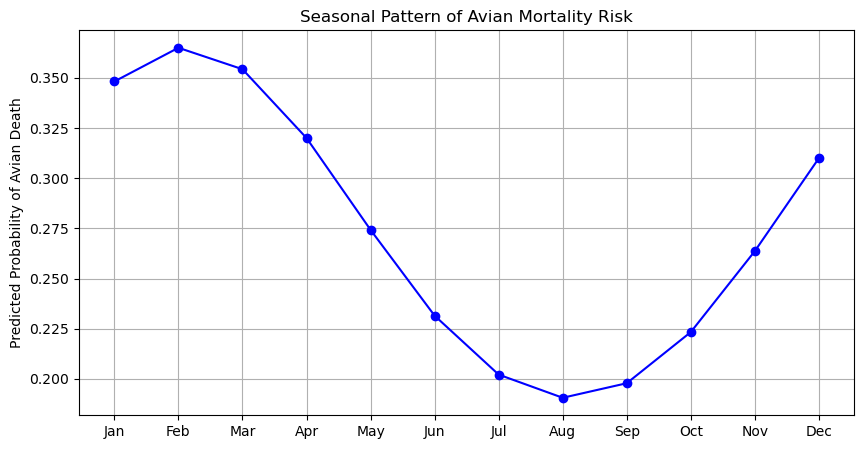

In [4]:
# Assuming these coefficients came from your model
sin_coeff = 0.4  # from model.coef_ for Month_Sin
cos_coeff = 0.2  # from model.coef_ for Month_Cos
intercept = -1.0 # from model.intercept_

# Calculate the seasonal component
seasonal_component = sin_coeff*month_sin + cos_coeff*month_cos

# Convert to probability scale
probabilities = 1 / (1 + np.exp(-(intercept + seasonal_component)))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(months, probabilities, 'b-o')
plt.xticks(months, ['Jan','Feb','Mar','Apr','May','Jun',
                   'Jul','Aug','Sep','Oct','Nov','Dec'])
plt.ylabel('Predicted Probability of Avian Death')
plt.title('Seasonal Pattern of Avian Mortality Risk')
plt.grid(True)
plt.show()